<a href="https://colab.research.google.com/github/VladimirVladetic/OSiRV-RoadSignDetection/blob/main/EDA_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, Input
from PIL import Image, ImageOps, ImageEnhance
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import shutil
from imblearn.under_sampling import RandomUnderSampler
import xml.etree.ElementTree as ET
from collections import defaultdict
from skimage import feature
from sklearn.preprocessing import LabelBinarizer
from skimage.morphology import erosion, dilation
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, InceptionV3
from google.colab import files


In [ ]:
def remove_images_with_zero_dimensions(images_array, class_label_array, bbox_array):
    indices_to_remove = []
    for i, image in enumerate(images_array):
        height, width, channels = image.shape
        if height == 32 or width == 32:
            indices_to_remove.append(i)
    images_array = np.delete(images_array, indices_to_remove, axis=0)
    class_label_array = np.delete(class_label_array, indices_to_remove, axis=0)
    bbox_array = np.delete(bbox_array, indices_to_remove, axis=0)

    return images_array, class_label_array, bbox_array, indices_to_remove

In [ ]:
def crop_images(images, bboxes):
    cropped_images = []
    for image, bbox in zip(images, bboxes):

        xmin, ymin, xmax, ymax = bbox
        xmin = max(0, int(xmin))
        ymin = max(0, int(ymin))
        xmax = min(image.shape[1], int(xmax))
        ymax = min(image.shape[0], int(ymax))
        cropped_image = image[ymin:ymax, xmin:xmax, :]
        cropped_images.append(cropped_image)

    return cropped_images

In [ ]:
def extract_features_edge(images, height, width):
    features = []
    for var_img  in tqdm(images):

        edge_channels = [feature.canny(var_img[:, :, i]) for i in range(3)]
        edges = np.stack(edge_channels, axis=-1)
        edges_image = Image.fromarray(edges.astype(np.uint8) * 255)
        edges_image = edges_image.resize((height, width), Image.ANTIALIAS)
        edges_image = np.array(edges_image)
        edges_image = edges_image / 255.0
        features.append(edges_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
def extract_features_edge_with_padding(images, height, width):
    features = []
    for var_img  in tqdm(images):

        padding_needed = False
        if var_img.shape[0] < height or var_img.shape[1] < width:
            padding_needed = True
        if padding_needed:
            pad_height = max(0, height - var_img.shape[0])
            pad_width = max(0, width - var_img.shape[1])
            top_pad = pad_height // 2
            bottom_pad = pad_height - top_pad
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            var_img = np.pad(var_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')

        edge_channels = [feature.canny(var_img[:, :, i]) for i in range(3)]
        edges = np.stack(edge_channels, axis=-1)
        edges_image = Image.fromarray(edges.astype(np.uint8) * 255)
        edges_image = edges_image.resize((height, width), Image.ANTIALIAS)
        edges_image = np.array(edges_image)
        edges_image = edges_image / 255.0
        features.append(edges_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
def extract_features_dilation(images, height, width):
    features = []
    for var_img in tqdm(images):
        r, g, b = var_img[:, :, 0], var_img[:, :, 1], var_img[:, :, 2]
        dilated_r = dilation(r)
        dilated_g = dilation(g)
        dilated_b = dilation(b)
        dilated_image = np.stack((dilated_r, dilated_g, dilated_b), axis=-1)
        dilated_image = (dilated_image * 255).astype(np.uint8)
        var_image = Image.fromarray(dilated_image)
        var_image = var_image.resize((height, width), Image.ANTIALIAS)
        var_image = np.array(var_image) / 255.0
        features.append(var_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
def extract_features_dilation_with_padding(images, height, width):
    features = []
    for var_img in tqdm(images):

        padding_needed = False
        if var_img.shape[0] < height or var_img.shape[1] < width:
            padding_needed = True
        if padding_needed:
            pad_height = max(0, height - var_img.shape[0])
            pad_width = max(0, width - var_img.shape[1])
            top_pad = pad_height // 2
            bottom_pad = pad_height - top_pad
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            var_img = np.pad(var_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')

        r, g, b = var_img[:, :, 0], var_img[:, :, 1], var_img[:, :, 2]
        dilated_r = dilation(r)
        dilated_g = dilation(g)
        dilated_b = dilation(b)
        dilated_image = np.stack((dilated_r, dilated_g, dilated_b), axis=-1)
        dilated_image = (dilated_image * 255).astype(np.uint8)
        var_image = Image.fromarray(dilated_image)
        var_image = var_image.resize((height, width), Image.ANTIALIAS)
        var_image = np.array(var_image) / 255.0
        features.append(var_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
def extract_features_erosion(images, height, width):
    features = []
    for var_img in tqdm(images):
        r, g, b = var_img[:, :, 0], var_img[:, :, 1], var_img[:, :, 2]
        eroded_r = erosion(r)
        eroded_g = erosion(g)
        eroded_b = erosion(b)
        eroded_image = np.stack((eroded_r, eroded_g, eroded_b), axis=-1)
        eroded_image = (eroded_image * 255).astype(np.uint8)
        var_image = Image.fromarray(eroded_image)
        var_image = var_image.resize((height, width), Image.ANTIALIAS)
        var_image = np.array(var_image) / 255.0
        features.append(var_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
def extract_features_erosion_with_padding(images, height, width):
    features = []
    for var_img in tqdm(images):

        padding_needed = False
        if var_img.shape[0] < height or var_img.shape[1] < width:
            padding_needed = True
        if padding_needed:
            pad_height = max(0, height - var_img.shape[0])
            pad_width = max(0, width - var_img.shape[1])
            top_pad = pad_height // 2
            bottom_pad = pad_height - top_pad
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            var_img = np.pad(var_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')

        r, g, b = var_img[:, :, 0], var_img[:, :, 1], var_img[:, :, 2]
        eroded_r = erosion(r)
        eroded_g = erosion(g)
        eroded_b = erosion(b)
        eroded_image = np.stack((eroded_r, eroded_g, eroded_b), axis=-1)
        eroded_image = (eroded_image * 255).astype(np.uint8)
        var_image = Image.fromarray(eroded_image)
        var_image = var_image.resize((height, width), Image.ANTIALIAS)
        var_image = np.array(var_image) / 255.0
        features.append(var_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
def extract_features_contrast(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = Image.fromarray(image, mode='RGB')
        r, g, b = var_img.split()
        r = ImageOps.equalize(r)
        g = ImageOps.equalize(g)
        b = ImageOps.equalize(b)
        var_img = Image.merge("RGB", (r, g, b))
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
def extract_features_contrast_with_padding(images, height, width):
    features = []
    for image in tqdm(images):

        padding_needed = False
        if image.shape[0] < height or image.shape[1] < width:
            padding_needed = True
        if padding_needed:
            pad_height = max(0, height - image.shape[0])
            pad_width = max(0, width - image.shape[1])
            top_pad = pad_height // 2
            bottom_pad = pad_height - top_pad
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            image = np.pad(image, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')

        var_img = Image.fromarray(image, mode='RGB')
        r, g, b = var_img.split()
        r = ImageOps.equalize(r)
        g = ImageOps.equalize(g)
        b = ImageOps.equalize(b)
        var_img = Image.merge("RGB", (r, g, b))
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
def display_acc_graph(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
    plt.title("Accuracy Graph")
    plt.legend()
    plt.figure()

def display_loss_graph(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label="Validation Loss")
    plt.title("Loss Graph")
    plt.legend()
    plt.show()

In [ ]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d andrewmvd/road-sign-detection
with zipfile.ZipFile('/content/road-sign-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

 99% 216M/218M [00:09<00:00, 26.3MB/s]
100% 218M/218M [00:09<00:00, 23.4MB/s]


In [ ]:
annotations_path = '/content/annotations'
annotations = os.listdir(annotations_path)

In [ ]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []
bboxes = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append("/content/images/" + img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)
        bboxes.append((xmin,ymin,xmax,ymax))

  0%|          | 0/877 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame({
                        'image_path': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'bboxes': bboxes,
                        'class_label': label_list})

classes = df['class_label'].unique().tolist()
classes

df['class_int'] = df['class_label'].apply(lambda x: classes.index(x))
# print(df.shape)
df.head()

,image_path,width,height,xmin,ymin,xmax,ymax,bboxes,class_label,class_int
0,/content/images/road336.png,300,400,113,181,155,222,"(113, 181, 155, 222)",speedlimit,0
1,/content/images/road340.png,300,400,95,280,160,346,"(95, 280, 160, 346)",speedlimit,0
2,/content/images/road748.png,300,400,72,210,91,228,"(72, 210, 91, 228)",speedlimit,0
3,/content/images/road748.png,300,400,96,209,114,227,"(96, 209, 114, 227)",speedlimit,0
4,/content/images/road119.png,400,267,225,31,337,144,"(225, 31, 337, 144)",speedlimit,0


In [ ]:
width = 224
height = 224
og_height = 400
og_width = 300

width_scale = width / og_width
height_scale = height / og_height

lb = LabelBinarizer()

images_array = []

image_paths = np.array(df['image_path'])

for image_path in image_paths:
    image = load_img(image_path, target_size=(height, width))
    images_array.append(np.array(image))

class_label_array = np.array(df['class_int'])
class_label_array = lb.fit_transform(class_label_array)

bbox_array = np.array(df['bboxes'])
bbox_array = np.array([list(map(float, box)) for box in bbox_array])
for bbox in bbox_array:
    bbox[0] *= width_scale
    bbox[1] *= height_scale
    bbox[2] *= width_scale
    bbox[3] *= height_scale

images_array, class_label_array, bbox_array, removed_indices = remove_images_with_zero_dimensions(images_array, class_label_array, bbox_array)

In [ ]:
trainImages, testImages, trainLabels, testLabels, trainBBoxes, testBBoxes, trainPaths, testPaths = train_test_split(
                         images_array,
                         class_label_array,
                         bbox_array,
                         image_paths,
                         test_size=0.2,
                         random_state=42)

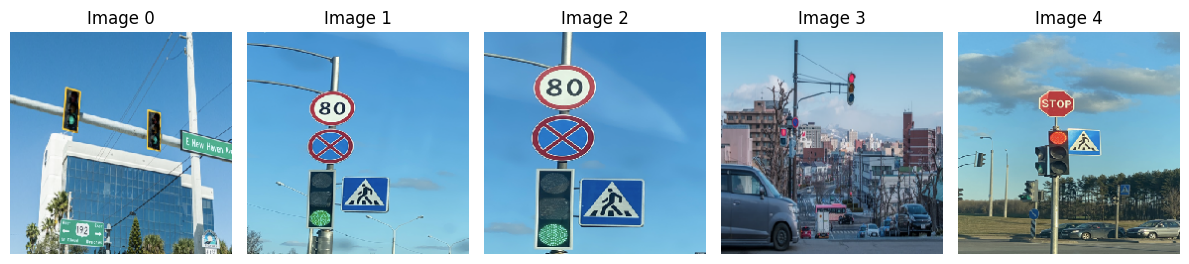

In [ ]:
indices_to_display = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = trainImages[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
inception = InceptionV3(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))
inception.trainable = False
flatten = inception.output
flatten = Flatten()(flatten)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
features = extract_features_edge(trainImages,height,width)

  0%|          | 0/995 [00:00<?, ?it/s]

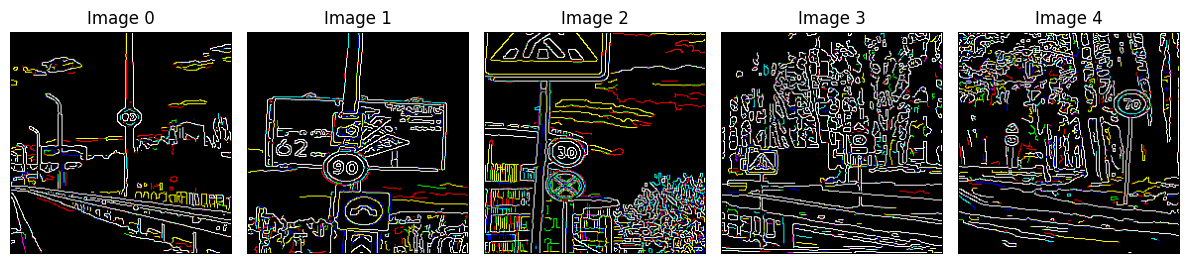

In [ ]:
indices_to_display = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = features[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
bboxHead = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(flatten)
bboxHead = Dropout(0.3)(bboxHead)
bboxHead = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(bboxHead)
bboxHead = Dropout(0.3)(bboxHead)
bboxHead = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(bboxHead)
bboxHead = Dropout(0.3)(bboxHead)
bboxHead = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(bboxHead)
bboxHead = Dense(4, activation="linear")(bboxHead)

In [ ]:
bboxmodel = Model(
    inputs=inception.input,
    outputs=bboxHead)

In [ ]:
INIT_LR = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 16

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr = ReduceLROnPlateau(factor=0.25, patience=3)

In [ ]:
opt = Adam(INIT_LR)

bboxmodel.compile(loss="mean_absolute_error",
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
history = bboxmodel.fit(
    features, trainBBoxes,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,lr],
    verbose=1)

In [ ]:
display_acc_graph(history)
display_loss_graph(history)

In [ ]:
features_test = extract_features_edge(testImages,224,224)

  0%|          | 0/249 [00:00<?, ?it/s]

In [ ]:
bbox_predictions = bboxmodel.predict(features_test)

In [ ]:
from shapely.geometry import box

def compute_iou(box1, box2):
    poly1 = box(box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3])
    poly2 = box(box2[0], box2[1], box2[0] + box2[2], box2[1] + box2[3])
    intersection_area = poly1.intersection(poly2).area
    union_area = poly1.union(poly2).area
    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou

def compute_average_iou(predictions, ground_truths):
    total_iou = 0.0
    num_predictions = len(predictions)

    for i in range(num_predictions):
        iou = compute_iou(predictions[i], ground_truths[i])
        total_iou += iou

    average_iou = total_iou / num_predictions
    return average_iou

In [ ]:
print("Average IoU:", compute_average_iou(bbox_predictions, testBBoxes))

In [ ]:
trainImages = crop_images(trainImages, trainBBoxes)

In [ ]:
features = extract_features_contrast_with_padding(trainImages,32,32)

  0%|          | 0/995 [00:00<?, ?it/s]

In [ ]:
indices_to_display = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = features[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
resnet = ResNet50(weights="imagenet",
                  include_top=False,
                  input_tensor=Input(shape=(32, 32, 3)))
resnet.trainable = False
flatten = resnet.output
flatten = Flatten()(flatten)

In [ ]:
softmaxHead = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(flatten)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(softmaxHead)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(softmaxHead)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(256, activation="relu")(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

In [ ]:
clasificationmodel = Model(
    inputs=resnet.input,
    outputs=softmaxHead)

In [ ]:
INIT_LR = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 16

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr = ReduceLROnPlateau(factor=0.5, patience=5)

In [ ]:
opt = Adam(INIT_LR)

clasificationmodel.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
history = clasificationmodel.fit(
    features, trainLabels,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,lr],
    verbose=1)

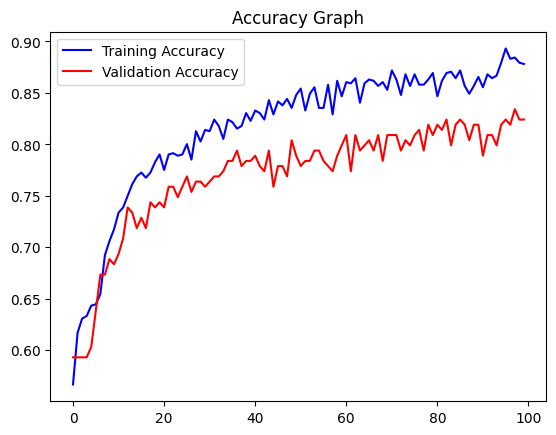

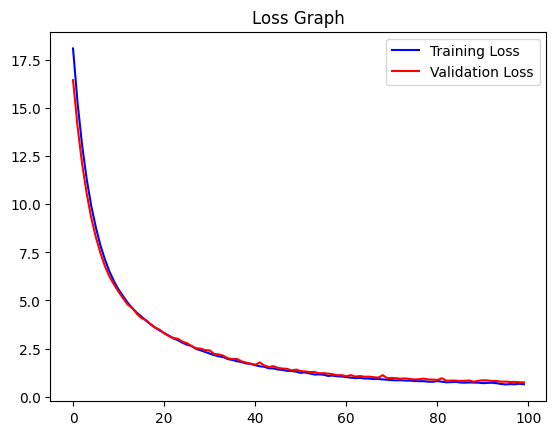

In [ ]:
display_acc_graph(history)
display_loss_graph(history)

In [ ]:
testImages = crop_images(testImages, testBBoxes)

In [ ]:
features_test = extract_features_dilation_with_padding(testImages,32,32)

In [ ]:
y_pred = clasificationmodel.predict(features_test)

y_pred = y_pred.argmax(axis=1)
testLabels = testLabels.argmax(axis=1)

8/8 [==============================] - 0s 19ms/step


In [ ]:
print(y_pred)

In [ ]:
!pip install scikit-plot

In [ ]:
print(testLabels)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import scikitplot as skplt

accuracy = accuracy_score(testLabels, y_pred)
print(classification_report(testLabels, y_pred))

In [ ]:
conf_matrix_age = confusion_matrix(testLabels, y_pred)
print(conf_matrix_age)

skplt.metrics.plot_confusion_matrix(testLabels, y_pred, figsize=(8, 6), cmap='Blues')
plt.xlabel('Predicted sign')
plt.ylabel('True sign')
plt.title('Confusion Matrix for road sign prediction')
plt.show()


In [ ]:
class_counts = df['class_label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['width'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df['height'], bins=30, color='red', edgecolor='black')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()